# FYP-DL: Random Forest - Countering Imbalance via Class Weights

Didn't get great results with Logistic Regression. FN and FP rates improved when considered on the basis of an individual class, but overall ROC remained the same, and FPs increased substantially.

Maybe random forest classifiers will do better?

# Imports

In [18]:
# For loading data from Drive
from google.colab import drive, files

# Standard Imports
import pandas as  pd
import os 
import numpy as np

from matplotlib import pyplot as plt 
%matplotlib inline 
from matplotlib import style 
style.use('ggplot')

# Sklearn - Model Selection
from sklearn.model_selection import RandomizedSearchCV, train_test_split 

# Sklearn - Model Evaluation 
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, confusion_matrix, \
plot_confusion_matrix, plot_roc_curve

# Sklearn - Random Forest
from sklearn.ensemble import RandomForestClassifier

# Sklearn - Class Weights
from sklearn.utils.class_weight import compute_class_weight

# Random Number Seeding
np.random.seed(0)

In [2]:
def get_classification_result(estimator, X, y_true, classifier_name=None,
                              normalize_conf_mat='all'):
    """Custom function to display classification results"""
    # Predictions will be used several times
    y_pred = estimator.predict(X) 

    # Display the classification report 
    print("CLASSIFICATION REPORT")
    print(classification_report(y_true, y_pred, labels=[0, 1], 
                                target_names=['Regular Consumer', 'Thieves'],))
    
    # Display the confusion matrix
    print("CONFUSION MATRIX")
    if (normalize_conf_mat=='rows'):
      normalize='true'
    elif (normalize_conf_mat=='cols'):
        normalize='pred'
    else:
      normalize=normalize_conf_mat

    # Use built-in function to get confusion matrix for this estimator
    conf_mat_display = plot_confusion_matrix(estimator=estimator, 
                                             X=X, 
                                             y_true=y_true, 
                                             labels=[0, 1],
                                             normalize=normalize, 
                                             display_labels=['Regular Consumers', 'Thieves'], 
                                             cmap=plt.cm.Blues)
    
    # Add a title (with optional classifier name)
    conf_mat_display.ax_.set_title("Confusion Matrix - {}".format(
        classifier_name if classifier_name is not None 
        else 'Test Classifier' ))
    
    # This will render the confusion matrix as an image
    print(conf_mat_display.confusion_matrix);
    plt.grid(False)       # Remove extra lines from confusion matrix

    roc_curve_display = plot_roc_curve(estimator, X, y_true)
    roc_curve_display.ax_.set_title('ROC Curve' +
                                    ('' if classifier_name is None else ' - {}'.format(classifier_name)), 
                                    fontsize=18);

# Importing Modules

In [3]:
!wget --quiet "https://raw.githubusercontent.com/SMS-NED16/FYP-DL/master/fyp-assignments/08_WDNN_Model/02_WDNN_py_files/pipelines.py"
!wget --quiet "https://raw.githubusercontent.com/SMS-NED16/FYP-DL/master/fyp-assignments/08_WDNN_Model/02_WDNN_py_files/plot_utils.py"
!wget --quiet "https://raw.githubusercontent.com/SMS-NED16/FYP-DL/master/fyp-assignments/08_WDNN_Model/02_WDNN_py_files/wdnn_transformers.py"
!wget --quiet "https://raw.githubusercontent.com/SMS-NED16/FYP-DL/master/fyp-assignments/08_WDNN_Model/02_WDNN_py_files/build_WDNN.py"

# Loading Data

In [4]:
# Mount Google Drive
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


In [5]:
# Defining filepaths
ROOT_DIR = "/content/drive/My Drive"
FYP_DIR = "EE 16-17 FYP DL Energy Theft Detection"
DATA_DIR = "Data/full-processing-data"
FILE_NAME = "outliersRemoved.csv"

# Create filepath
FILE_PATH = os.path.join(ROOT_DIR, FYP_DIR, DATA_DIR, FILE_NAME)

In [6]:
# Print the filepath for checking
print(FILE_PATH)

/content/drive/My Drive/EE 16-17 FYP DL Energy Theft Detection/Data/full-processing-data/outliersRemoved.csv


In [7]:
df = pd.read_csv(FILE_PATH)
df.head()

,CONS_NO,FLAG,2014-01-01,2014-01-02,2014-01-03,2014-01-04,2014-01-05,2014-01-06,2014-01-07,2014-01-08,2014-01-09,2014-01-10,2014-01-11,2014-01-12,2014-01-13,2014-01-14,2014-01-15,2014-01-16,2014-01-17,2014-01-18,2014-01-19,2014-01-20,2014-01-21,2014-01-22,2014-01-23,2014-01-24,2014-01-25,2014-01-26,2014-01-27,2014-01-28,2014-01-29,2014-01-30,2014-01-31,2014-02-01,2014-02-02,2014-02-03,2014-02-04,2014-02-05,2014-02-06,2014-02-07,...,2016-09-22,2016-09-23,2016-09-24,2016-09-25,2016-09-26,2016-09-27,2016-09-28,2016-09-29,2016-09-30,2016-10-01,2016-10-02,2016-10-03,2016-10-04,2016-10-05,2016-10-06,2016-10-07,2016-10-08,2016-10-09,2016-10-10,2016-10-11,2016-10-12,2016-10-13,2016-10-14,2016-10-15,2016-10-16,2016-10-17,2016-10-18,2016-10-19,2016-10-20,2016-10-21,2016-10-22,2016-10-23,2016-10-24,2016-10-25,2016-10-26,2016-10-27,2016-10-28,2016-10-29,2016-10-30,2016-10-31
0,0387DD8A07E07FDA6271170F86AD9151,1,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.0,0.00,...,8.56,10.48,8.20,12.53,7.90,8.58,10.12,9.96,7.60,18.19,10.93,11.41,19.92,10.70,9.20,6.77,6.760000,6.150000,6.500000,8.080000,7.97,8.810000,7.370000,11.720000,11.020000,8.180000,7.330000,6.710000,8.520000,6.310000,7.18,8.070000,8.090000,9.530000,5.480000,8.750000,9.300000,7.540000,9.160000,6.740000
1,01D6177B5D4FFE0CABA9EF17DAFC2B84,1,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.0,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,4B75AC4F2D8434CFF62DB64D0BB43103,1,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.0,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,8.34,13.483126,13.483126,13.483126,13.483126,12.73,13.483126,13.483126,13.483126,13.483126,13.483126,13.483126,13.483126,13.483126,13.483126,10.95,13.483126,13.483126,13.483126,13.483126,13.483126,13.483126,13.483126,13.483126,13.483126
3,B32AC8CC6D5D805AC053557AB05F5343,1,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.0,0.00,...,17.30,16.95,8.25,22.76,14.07,20.70,6.50,9.99,18.59,16.79,26.82,14.70,16.05,24.10,12.64,10.85,11.770000,13.030000,12.260000,15.660000,13.43,15.030000,14.610000,13.970000,15.070000,14.110000,14.770000,11.720000,11.730000,11.980000,12.81,15.120000,17.260000,14.910000,19.590000,20.790000,17.950000,19.260000,14.460000,11.720000
4,EDFC78B07BA2908B3395C4EB2304665E,1,2.9,5.64,6.99,3.32,3.61,5.35,4.73,3.68,3.53,3.42,3.81,4.58,3.56,4.25,3.86,3.53,3.41,0.85,0.88,3.81,6.51,9.19,7.79,7.02,7.25,6.37,6.43,7.89,7.46,7.95,7.59,4.84,6.06,5.6,6.72,7.29,5.6,6.28,...,9.56,9.48,10.60,10.06,10.79,10.91,17.77,10.37,13.51,14.13,17.44,15.96,12.18,18.54,13.44,11.68,9.150000,9.160000,10.190000,10.310000,8.03,10.080000,10.340000,11.240000,15.140000,14.360000,12.390000,10.360000,9.290000,7.910000,14.21,10.220000,8.470000,6.110000,6.100000,6.730000,7.520000,10.890000,9.860000,8.720000


# Train-Test Split

In [8]:
features, labels = df.iloc[:, 2:], df.iloc[:, 1]

In [9]:
X_train_val, X_test, y_train_val, y_test = train_test_split(features, labels, 
                                                    test_size=0.2, 
                                                    random_state=0, 
                                                    stratify=labels.values)

In [10]:
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, 
                                                  random_state=0, 
                                                  test_size=0.2, 
                                                  stratify=y_train_val.values)

# Feature Scaling

In [11]:
# Import the pipeline functions from the pipeline modules
from pipelines import get_pipeline_1D, get_pipeline_2D

# Creating pipeline objects
pipeline_1D = get_pipeline_1D(scaling_strategy='Standard')

# Fit and then transform the pipelines to the training data first 
X_train_val_1D = pipeline_1D.fit_transform(X_train_val)
X_train_1D = pipeline_1D.fit_transform(X_train)
X_val_1D = pipeline_1D.fit_transform(X_val)
X_test_1D = pipeline_1D.fit_transform(X_test)

# Class Weights 01 - `sklearn` API

In [12]:
# Compute class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train_val
)

# Create a dictionary that can be passed to an `sklearn` estimator
cw_sklearn = dict(zip([0, 1], class_weights))

# Output this: does it make sense?
cw_sklearn

{0: 0.5466376390904693, 1: 5.860477178423237}

# Random Forest Classifier - Zheng

In [15]:
rf_clf = RandomForestClassifier(n_estimators=200, criterion='gini', 
                                random_state=0, verbose=2, 
                                class_weight=cw_sklearn)

In [ ]:
rf_clf.fit(X_train_val_1D, y_train_val)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


CLASSIFICATION REPORT
                  precision    recall  f1-score   support

Regular Consumer       0.92      1.00      0.96      7752
         Thieves       0.76      0.04      0.08       723

        accuracy                           0.92      8475
       macro avg       0.84      0.52      0.52      8475
    weighted avg       0.90      0.92      0.88      8475

CONFUSION MATRIX


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[[0.91351032 0.00117994]
 [0.08165192 0.00365782]]


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.5s finished


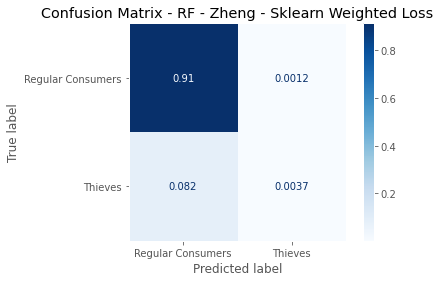

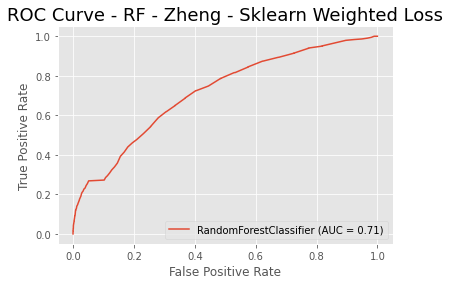

In [19]:
get_classification_result(estimator=rf_clf, X=X_test_1D, y_true=y_test, 
                          classifier_name="RF - Zheng - Sklearn Weighted Loss")

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


CLASSIFICATION REPORT
                  precision    recall  f1-score   support

Regular Consumer       0.92      1.00      0.96      7752
         Thieves       0.76      0.04      0.08       723

        accuracy                           0.92      8475
       macro avg       0.84      0.52      0.52      8475
    weighted avg       0.90      0.92      0.88      8475

CONFUSION MATRIX


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[[0.99871001 0.00128999]
 [0.9571231  0.0428769 ]]


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.5s finished


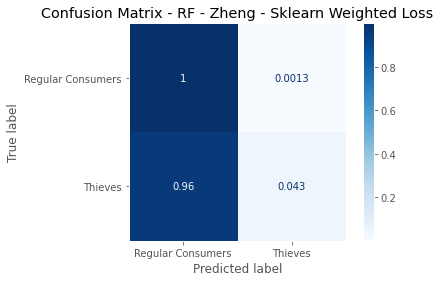

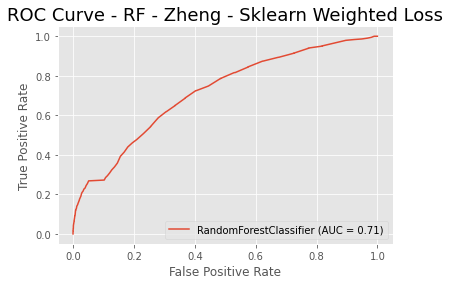

In [21]:
get_classification_result(estimator=rf_clf, X=X_test_1D, y_true=y_test, 
                          classifier_name="RF - Zheng - Sklearn Weighted Loss",
                          normalize_conf_mat="rows")

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


CLASSIFICATION REPORT
                  precision    recall  f1-score   support

Regular Consumer       0.92      1.00      0.96      7752
         Thieves       0.76      0.04      0.08       723

        accuracy                           0.92      8475
       macro avg       0.84      0.52      0.52      8475
    weighted avg       0.90      0.92      0.88      8475

CONFUSION MATRIX


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[[0.91795115 0.24390244]
 [0.08204885 0.75609756]]


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.5s finished


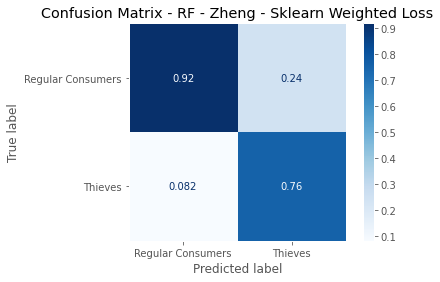

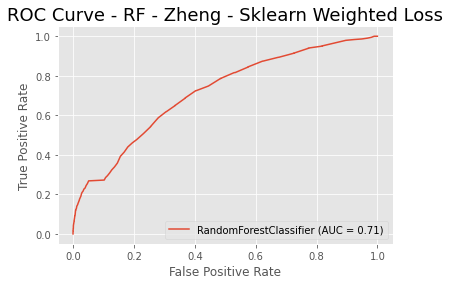

In [22]:
get_classification_result(estimator=rf_clf, X=X_test_1D, y_true=y_test, 
                          classifier_name="RF - Zheng - Sklearn Weighted Loss",
                          normalize_conf_mat="cols")

#  Classifier without Weights

In [ ]:
rf_clf = RandomForestClassifier(n_estimators=200, criterion='gini', 
                                    random_state=0, verbose=2)
rf_clf.fit(X_train_val_1D, y_train_val)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


CLASSIFICATION REPORT
                  precision    recall  f1-score   support

Regular Consumer       0.92      1.00      0.96      7752
         Thieves       0.85      0.03      0.06       723

        accuracy                           0.92      8475
       macro avg       0.88      0.51      0.51      8475
    weighted avg       0.91      0.92      0.88      8475

CONFUSION MATRIX


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[[9.14218289e-01 4.71976401e-04]
 [8.27138643e-02 2.59587021e-03]]


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.7s finished


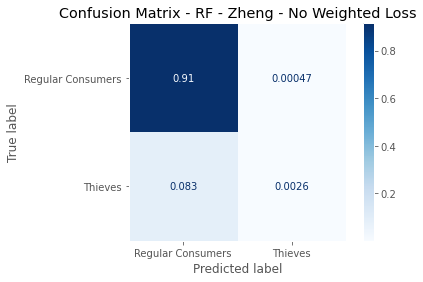

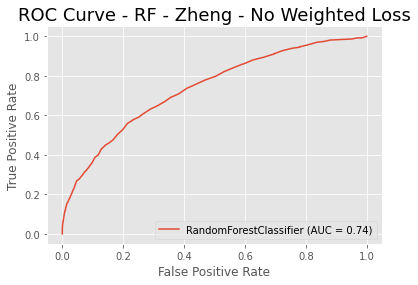

In [24]:
get_classification_result(rf_clf, X_test_1D, y_test, "RF - Zheng - No Weighted Loss", 
                          normalize_conf_mat='all')

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


CLASSIFICATION REPORT
                  precision    recall  f1-score   support

Regular Consumer       0.92      1.00      0.96      7752
         Thieves       0.85      0.03      0.06       723

        accuracy                           0.92      8475
       macro avg       0.88      0.51      0.51      8475
    weighted avg       0.91      0.92      0.88      8475

CONFUSION MATRIX


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[[9.99484004e-01 5.15995872e-04]
 [9.69571231e-01 3.04287690e-02]]


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.7s finished


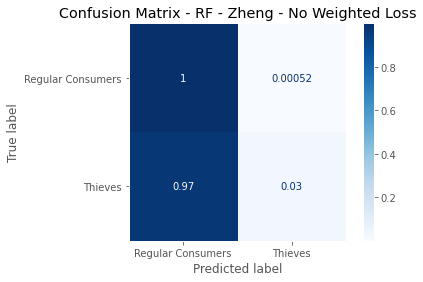

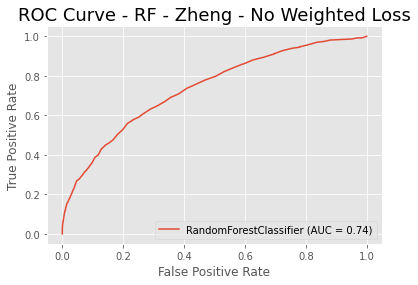

In [25]:
get_classification_result(rf_clf, X_test_1D, y_test, "RF - Zheng - No Weighted Loss", 
                          normalize_conf_mat='rows')

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


CLASSIFICATION REPORT
                  precision    recall  f1-score   support

Regular Consumer       0.92      1.00      0.96      7752
         Thieves       0.85      0.03      0.06       723

        accuracy                           0.92      8475
       macro avg       0.88      0.51      0.51      8475
    weighted avg       0.91      0.92      0.88      8475

CONFUSION MATRIX


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[[0.9170316  0.15384615]
 [0.0829684  0.84615385]]


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.7s finished


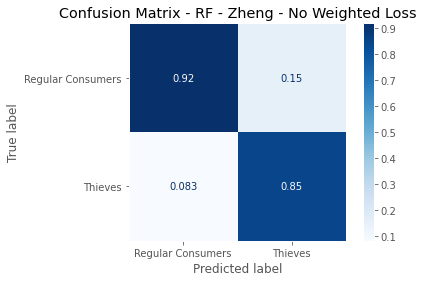

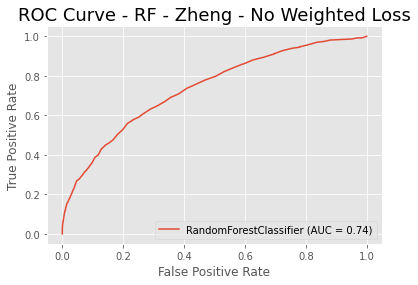

In [26]:
get_classification_result(rf_clf, X_test_1D, y_test, "RF - Zheng - No Weighted Loss", 
                          normalize_conf_mat='cols')

# MinMax Scaling

In [27]:
# Creating pipeline objects
pipeline_1D = get_pipeline_1D(scaling_strategy='MinMax')

# Fit and then transform the pipelines to the training data first 
X_train_val_1D = pipeline_1D.fit_transform(X_train_val)
X_train_1D = pipeline_1D.fit_transform(X_train)
X_val_1D = pipeline_1D.fit_transform(X_val)
X_test_1D = pipeline_1D.fit_transform(X_test)

# RF Classifier 01 - Weights

In [ ]:
rf_clf = RandomForestClassifier(n_estimators=200, criterion='gini', 
                                random_state=0, verbose=2, 
                                class_weight=cw_sklearn)
rf_clf.fit(X_train_val_1D, y_train_val)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


CLASSIFICATION REPORT
                  precision    recall  f1-score   support

Regular Consumer       0.92      1.00      0.96      7752
         Thieves       0.82      0.05      0.09       723

        accuracy                           0.92      8475
       macro avg       0.87      0.52      0.53      8475
    weighted avg       0.91      0.92      0.88      8475

CONFUSION MATRIX


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[[0.91374631 0.00094395]
 [0.08106195 0.00424779]]


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.5s finished


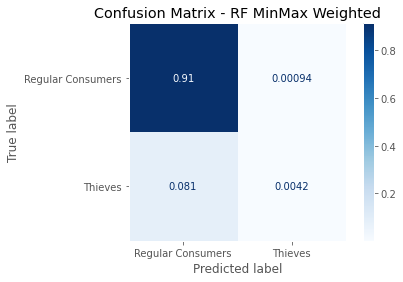

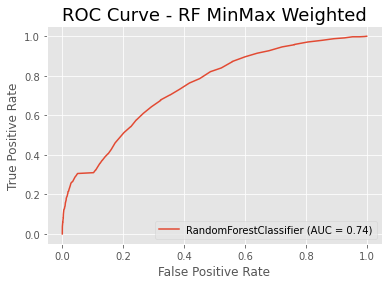

In [29]:
get_classification_result(rf_clf, X_test_1D, y_test,  
                          "RF MinMax Weighted",
                          normalize_conf_mat="all")

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


CLASSIFICATION REPORT
                  precision    recall  f1-score   support

Regular Consumer       0.92      1.00      0.96      7752
         Thieves       0.82      0.05      0.09       723

        accuracy                           0.92      8475
       macro avg       0.87      0.52      0.53      8475
    weighted avg       0.91      0.92      0.88      8475

CONFUSION MATRIX


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[[0.99896801 0.00103199]
 [0.95020747 0.04979253]]


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.5s finished


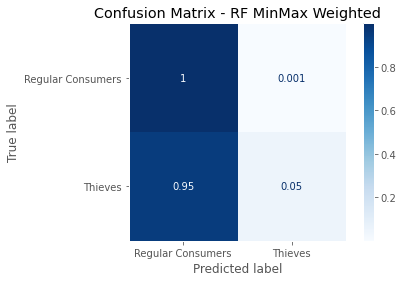

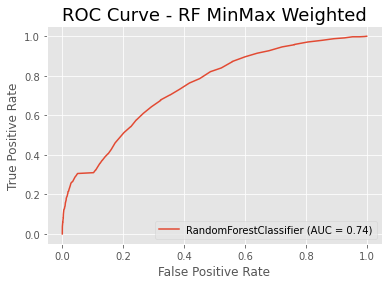

In [30]:
get_classification_result(rf_clf, X_test_1D, y_test,  
                          "RF MinMax Weighted",
                          normalize_conf_mat="rows")

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


CLASSIFICATION REPORT
                  precision    recall  f1-score   support

Regular Consumer       0.92      1.00      0.96      7752
         Thieves       0.82      0.05      0.09       723

        accuracy                           0.92      8475
       macro avg       0.87      0.52      0.53      8475
    weighted avg       0.91      0.92      0.88      8475

CONFUSION MATRIX


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[[0.918515   0.18181818]
 [0.081485   0.81818182]]


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.5s finished


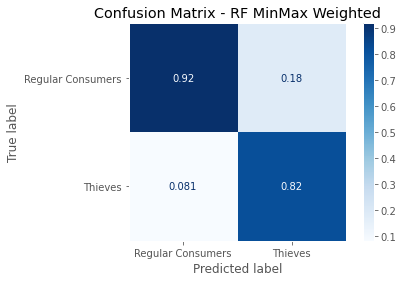

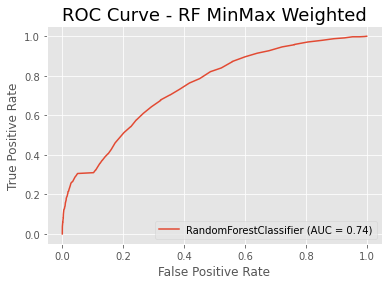

In [31]:
get_classification_result(rf_clf, X_test_1D, y_test,  
                          "RF MinMax Weighted",
                          normalize_conf_mat="cols")

# Without Weights

In [ ]:
rf_clf = RandomForestClassifier(n_estimators=200, criterion='gini', 
                                random_state=0, verbose=2)
rf_clf.fit(X_train_val_1D, y_train_val)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


CLASSIFICATION REPORT
                  precision    recall  f1-score   support

Regular Consumer       0.92      1.00      0.96      7752
         Thieves       0.84      0.04      0.08       723

        accuracy                           0.92      8475
       macro avg       0.88      0.52      0.52      8475
    weighted avg       0.91      0.92      0.88      8475

CONFUSION MATRIX


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[[9.13982301e-01 7.07964602e-04]
 [8.16519174e-02 3.65781711e-03]]


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.6s finished


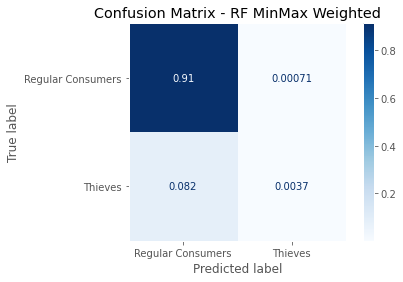

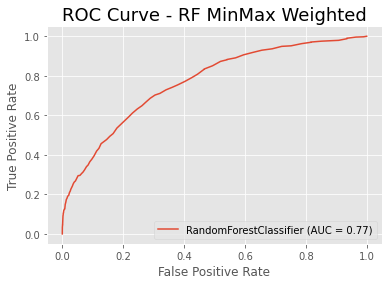

In [35]:
get_classification_result(rf_clf, X_test_1D, y_test,  
                          "RF MinMax Weighted",
                          normalize_conf_mat="all")

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


CLASSIFICATION REPORT
                  precision    recall  f1-score   support

Regular Consumer       0.92      1.00      0.96      7752
         Thieves       0.84      0.04      0.08       723

        accuracy                           0.92      8475
       macro avg       0.88      0.52      0.52      8475
    weighted avg       0.91      0.92      0.88      8475

CONFUSION MATRIX


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[[9.99226006e-01 7.73993808e-04]
 [9.57123098e-01 4.28769018e-02]]


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.5s finished


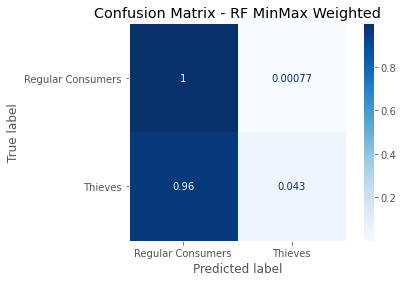

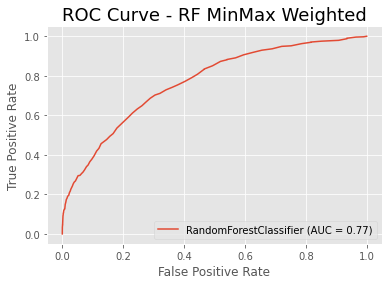

In [36]:
get_classification_result(rf_clf, X_test_1D, y_test,  
                          "RF MinMax Weighted",
                          normalize_conf_mat="rows")

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


CLASSIFICATION REPORT
                  precision    recall  f1-score   support

Regular Consumer       0.92      1.00      0.96      7752
         Thieves       0.84      0.04      0.08       723

        accuracy                           0.92      8475
       macro avg       0.88      0.52      0.52      8475
    weighted avg       0.91      0.92      0.88      8475

CONFUSION MATRIX


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[[0.91799005 0.16216216]
 [0.08200995 0.83783784]]


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.6s finished


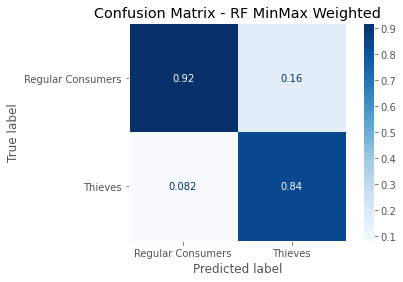

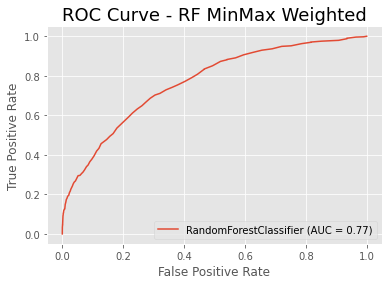

In [37]:
get_classification_result(rf_clf, X_test_1D, y_test,  
                          "RF MinMax Weighted",
                          normalize_conf_mat="cols")